# Proyek Movie Recommendation Nurul Tazkiyah Adam

# **1. Data Understanding**

## Import Library

In [3]:
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Download Dataset

dataset yang digunakan pada proyek ini bisa diakses melalui [tautan ini ](kaggle.com/datasets/rohan4050/movie-recommendation-data). 

In [4]:
!pip install -q kaggle

In [5]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!chmod 600 /content/kaggle.json

In [7]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d rohan4050/movie-recommendation-data

 61% 8.00M/13.1M [00:00<00:00, 82.2MB/s]
100% 13.1M/13.1M [00:00<00:00, 74.4MB/s]


In [8]:
local_zip = '/content/movie-recommendation-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

dalam dataset terdapat 


*   folder ml-latest-small, dengan isi file:
    - links.csv
    - movies.csv
    - ratings.csv
    - tags.csv
*   file movies_metadata.csv

namun pada proyek ini hanya akan menggunakan file `movies.csv` dan `ratings.csv`



## Univariate Exploratory Data Analysis

In [9]:
movies = pd.read_csv('/content/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')

print(f'Jumlah data movies sebanyak {movies.shape[0]}')
print(f'Jumlah variabel pada data movies sebanyak {movies.shape[1]} variabel')
print(f'Jumlah data ratings sebanyak {ratings.shape[0]}')
print(f'Jumlah variabel pada data ratings sebanyak {ratings.shape[1]} variabel')

Jumlah data movies sebanyak 9742
Jumlah variabel pada data movies sebanyak 3 variabel
Jumlah data ratings sebanyak 100836
Jumlah variabel pada data ratings sebanyak 4 variabel


### **Dataset Movies**

In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Variable dataset movies terbagi 3 yakni:
- `movieId` -> ID film
- `title` -> Judul film
- `genres` -> Genre film

dengan detail tipe data sebagai berikut



In [11]:
movies.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [12]:
print(f'Cek Missing Value Pada Variable Dataset Movies:')
print(f'- movieId sebanyak {movies.movieId.isnull().sum()}')
print(f'- title sebanyak {movies.title.isnull().sum()}')
print(f'- movieId sebanyak {movies.genres.isnull().sum()}')

Cek Missing Value Pada Variable Dataset Movies:
- movieId sebanyak 0
- title sebanyak 0
- movieId sebanyak 0


In [13]:
print(f'Cek Duplikasi Dataset Movies: {movies.duplicated().sum()} duplikasi')

Cek Duplikasi Dataset Movies: 0 duplikasi


In [14]:
print(f'Cek Data Unique Pada Variable Dataset Movies:')
print(f'- movieId sebanyak {movies.movieId.nunique()}')
print(f'- title sebanyak {movies.title.nunique()}')
print(f'- movieId sebanyak {movies.genres.nunique()}')

Cek Data Unique Pada Variable Dataset Movies:
- movieId sebanyak 9742
- title sebanyak 9737
- movieId sebanyak 951


### **Dataset Ratings**

In [15]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Variable dataset ratings terbagi 4 yakni:
- `userId` -> ID User pemberi rating
- `movieId` -> ID film yang dirating
- `rating` -> Rating film yang diberikan user
- `timestamp` -> Waktu rating terekam

dengan detail tipe data sebagai berikut

In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [17]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


setelah dicek, didapatkan informasi skala dari rating film yakni rating 0,5 sampai rating 5.

In [18]:
print(f'Cek Missing Value Pada Variable Dataset Ratings:')
print(f'- userId sebanyak {ratings.userId.isnull().sum()}')
print(f'- movieId sebanyak {ratings.movieId.isnull().sum()}')
print(f'- rating sebanyak {ratings.rating.isnull().sum()}')
print(f'- timestamp sebanyak {ratings.timestamp.isnull().sum()}')

Cek Missing Value Pada Variable Dataset Ratings:
- userId sebanyak 0
- movieId sebanyak 0
- rating sebanyak 0
- timestamp sebanyak 0


In [19]:
print(f'Cek Duplikasi Dataset Ratings: {ratings.duplicated().sum()} duplikasi')

Cek Duplikasi Dataset Ratings: 0 duplikasi


In [20]:
print(f'Cek Data Unique Pada Variable Dataset Ratings:')
print(f'- userId sebanyak {ratings.userId.nunique()}')
print(f'- movieId sebanyak {ratings.movieId.nunique()}')
print(f'- rating sebanyak {ratings.rating.nunique()}')
print(f'- timestamp sebanyak {ratings.timestamp.nunique()}')

Cek Data Unique Pada Variable Dataset Ratings:
- userId sebanyak 610
- movieId sebanyak 9724
- rating sebanyak 10
- timestamp sebanyak 85043


# **2. Data Preparation**

## Pembersihan Missing Value

In [21]:
movies.dropna(axis=0, inplace=True)
ratings.dropna(axis=0, inplace=True)

## Sorting Data Rating Berdasarkan User ID Kemudian Menjadikan integer

In [22]:
ratings = ratings.sort_values('userId').astype('int') 

## Pembersihan Duplikasi Data 

In [23]:
movies.drop_duplicates(subset=['title'], keep='first', inplace=True)
ratings.drop_duplicates(subset=['userId','movieId'], keep='first', inplace=True)

## Penggabungan Dataset

In [27]:
merge_dataset = pd.merge(ratings, movies, how='left', on='movieId')
movierating = merge_dataset.copy().drop('timestamp', axis=1)
movierating.head()

,userId,movieId,rating,title,genres
0,1,1,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2329,5,American History X (1998),Crime|Drama
2,1,2338,2,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
3,1,2353,5,Enemy of the State (1998),Action|Thriller
4,1,2366,4,King Kong (1933),Action|Adventure|Fantasy|Horror


menghapus missing values setelah dataset digabungkan

In [30]:
movierating = movierating[~pd.isnull(movierating['genres'])]

print(f'Setelah menggabungkan dataset dan menghapus missing values didapatkan sebanyak:')
print(f'- {movierating.shape[0]} baris data')
print(f'- {movierating.shape[1]} kolom / variable')


Setelah menggabungkan dataset dan menghapus missing values didapatkan sebanyak:
- 100830 baris data
- 5 kolom / variable


# **3. Model Development**

- # **Content Based Filtering**

**TF- IDF Vectorizer** 
melakukan inisialisasi TfidfVectorizer, kemudian perhitungan idf pada data film dan melakukan array dari fitur index integer ke fitur nama


In [31]:
tfid = TfidfVectorizer(stop_words='english')
tfid.fit(movies['genres'])
tfid.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'genres',
 'horror',
 'imax',
 'listed',
 'musical',
 'mystery',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

**Transform Data Film Pada Kolom Genres ke bentuk vektor Matrix**

In [32]:
tfidf_matrix = tfid.fit_transform(movies['genres']) 
tfidf_matrix.shape

(9737, 23)

**Menghitung Cosine Similarity**

In [33]:
cosim = cosine_similarity(tfidf_matrix)
cosim

array([[1.        , 0.81357359, 0.15270879, ..., 0.        , 0.42101966,
        0.2675912 ],
       [0.81357359, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15270879, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57067944],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42101966, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.2675912 , 0.        , 0.57067944, ..., 0.        , 0.        ,
        1.        ]])

**Dataframe baru berdasarkan Cosine Similarity**

In [34]:
cosim_df = pd.DataFrame(cosim, index=movies['title'], columns=movies['title'])
print('Shape:', cosim_df.shape)
cosim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (9737, 9737)


title,Blue Crush (2002),High Society (1956),Once Bitten (1985),"Onion Movie, The (2008)",God's Not Dead (2014),Teacher's Pet (1958),Maniac Cop (1988),"General's Daughter, The (1999)",RocketMan (a.k.a. Rocket Man) (1997),"Eagle Has Landed, The (1976)"
title,,,,,,,,,,
"Chorus, The (Choristes, Les) (2004)",0.399315,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.307214,0.000000,0.391760
Performance (1970),0.161902,0.000000,0.000000,0.000000,0.405449,0.000000,0.632371,0.757712,0.000000,0.158839
"Yearling, The (1946)",0.175579,0.000000,0.000000,0.000000,0.439701,0.000000,0.000000,0.135082,0.482512,0.172257
"Tuskegee Airmen, The (1995)",0.156436,0.000000,0.000000,0.000000,0.391760,0.000000,0.000000,0.120354,0.000000,1.000000
Requiem for a Heavyweight (1962),0.399315,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.307214,0.000000,0.391760
"Fireworks, Should We See It from the Side or the Bottom? (2017)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Babylon 5: The Legend of the Rangers: To Live and Die in Starlight (2002),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680002,0.000000
Tron: Legacy (2010),0.255458,0.000000,0.000000,0.000000,0.000000,0.000000,0.151565,0.000000,0.395426,0.000000
The Brothers Grimsby (2016),0.000000,0.351838,0.509561,1.000000,0.000000,0.570679,0.000000,0.000000,0.284756,0.000000


dari hasil diatas didapatkan similarity matrix pada setiap film

## **Test Model Recommendation Content Based Filtering**


pendefinisian fungsi movie_recom untuk menampilkan hasil rekomendasi film berdasarkan kesamaan genre dari satu judul film

In [38]:
def movie_recom(movies_title, 
                         similarity_data=cosim_df, 
                         items=movies[['movieId','title','genres']],
                         k=10):
   
    index = similarity_data.loc[:, movies_title].to_numpy().argpartition(
        range(-1, -k, -1)
    )

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(movies_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [43]:
find_movie = movies[movies['title'] == 'American History X (1998)']
find_movie

,movieId,title,genres
1734,2329,American History X (1998),Crime|Drama


In [44]:
movie_title = 'American History X (1998)'
movie_recomend = movie_recom(movie_title)
movie_recomend

,title,movieId,genres
0,People I Know (2002),6330,Crime|Drama
1,"United States of Leland, The (2003)",7377,Crime|Drama
2,Above the Rim (1994),409,Crime|Drama
3,Road to Perdition (2002),5464,Crime|Drama
4,"Virgin Spring, The (Jungfrukällan) (1960)",7820,Crime|Drama
5,Who'll Stop the Rain (1978),4695,Crime|Drama
6,"Prophet, A (Un Prophète) (2009)",73344,Crime|Drama
7,Tsotsi (2005),44204,Crime|Drama
8,"Godfather: Part II, The (1974)",1221,Crime|Drama
9,Tattooed Life (Irezumi ichidai) (1965),63768,Crime|Drama


Hasil uji rekomendasi di atas berhasil. Dapat dilihat bahwa sistem yang telah dirancang memberikan rekomendasi 10 judul film yang sesuai berdasarkan genre yang sama dengan satu judul film yang dipilih. Pada kasus ini menggunakan sample film *American History X (1998)* yang memiliki genre Crime dan Drama.

- # **Collaborative Filtering**

**Proses encoding fitur userId pada dataset menjadi array**


mengubah unique user id menjadi list, kemudian encoding User ID, lalu mengubah encoding angka ke userID

In [48]:
user_id = movierating['userId'].unique().tolist()
 
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
 
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}

**Proses encoding fitur movieId pada dataset  menjadi array**

mengubah unique  movie id menjadi list, kemudian encoding movie ID, lalu mengubah encoding angka ke movieID

In [50]:
movie_id = movierating['movieId'].unique().tolist()
 
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_id)}
 
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_id)}

**Mapping User ID ke dataframe user dan Movie ID ke dataframe movie**

In [51]:
movierating['user'] = movierating['userId'].map(user_to_user_encoded)
movierating['movie'] = movierating['movieId'].map(movie_to_movie_encoded)
movierating.head()

,userId,movieId,rating,title,genres,user,movie
0,1,1,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0
1,1,2329,5,American History X (1998),Crime|Drama,0,1
2,1,2338,2,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller,0,2
3,1,2353,5,Enemy of the State (1998),Action|Thriller,0,3
4,1,2366,4,King Kong (1933),Action|Adventure|Fantasy|Horror,0,4


In [54]:
num_users = len(user_to_user_encoded)
print(f'Jumlah Pengguna Sebanyak {num_users}')

num_movie = len(movie_encoded_to_movie)
print(f'Jumlah Movie Sebanyak {num_movie}')

movierating['rating'] = movierating['rating'].values.astype(np.float32)

min_rating = min(movierating['rating'])
print(f'Nilai Rating Terkecil: {min_rating}')

max_rating = max(movierating['rating'])
print(f'Nilai Rating Terbesar: {max_rating}')

Jumlah Pengguna Sebanyak 610
Jumlah Movie Sebanyak 9719
Nilai Rating Terkecil: 0.0
Nilai Rating Terbesar: 5.0


### **Pembagian Data Training dan Validasi**

mengacak dataset

In [55]:
movierating = movierating.sample(frac=1, random_state=42)
movierating.head()

,userId,movieId,rating,title,genres,user,movie
27969,191,99,5.0,Heidi Fleiss: Hollywood Madam (1995),Documentary,190,5551
44012,294,2060,2.0,BASEketball (1998),Comedy,293,1463
70876,453,3536,4.0,Keeping the Faith (2000),Comedy|Drama|Romance,452,1520
6188,42,292,3.0,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,41,660
34902,233,2858,3.0,American Beauty (1999),Drama|Romance,232,96


mendeklarasikan x untuk mencocokkan data pengguna dan film menjadi satu value, lalu mendeklarasikan y untuk rating dari hasil, selanjutnya membagi dataset dengan skala data **training 80% dan validasi 20%**

In [57]:
x = movierating[['user', 'movie']].values
y = movierating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.8 * movierating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### **Melatih Model**



Pembuatan Kelas dan Inisialisasi Fungsi

In [65]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(5e-7)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.movie_embedding = layers.Embedding(
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(5e-7)
    )
    self.movie_bias = layers.Embedding(num_movie, 1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x)

In [69]:
#memanggil kelas
model = RecommenderNet(num_users, num_movie, 50) 

#mengcompile model
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()]]
)

#callback
iniCallbacks = EarlyStopping(
    min_delta=0.0001,
    patience=7,
    restore_best_weights=True,
)

In [70]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[iniCallbacks]
)

Epoch 1/100
1261/1261 [==============================] - 13s 9ms/step - loss: 0.6386 - mean_absolute_error: 0.1807 - root_mean_squared_error: 0.2233 - val_loss: 0.6190 - val_mean_absolute_error: 0.1609 - val_root_mean_squared_error: 0.2018
Epoch 2/100
1261/1261 [==============================] - 11s 9ms/step - loss: 0.6149 - mean_absolute_error: 0.1555 - root_mean_squared_error: 0.1971 - val_loss: 0.6184 - val_mean_absolute_error: 0.1605 - val_root_mean_squared_error: 0.2009
Epoch 3/100
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6096 - mean_absolute_error: 0.1492 - root_mean_squared_error: 0.1912 - val_loss: 0.6144 - val_mean_absolute_error: 0.1560 - val_root_mean_squared_error: 0.1966
Epoch 4/100
1261/1261 [==============================] - 12s 9ms/step - loss: 0.6084 - mean_absolute_error: 0.1477 - root_mean_squared_error: 0.1898 - val_loss: 0.6142 - val_mean_absolute_error: 0.1561 - val_root_mean_squared_error: 0.1965
Epoch 5/100
1261/1261 [=================

### **Test Model Recommedation Collaborative Filtering**

Mengambil Datasampel Pengguna

In [71]:
user_ID = movierating.userId.sample(1).iloc[0]
movie_watched_by_user = movierating[movierating.userId == user_ID]
 
movie_not_watched = movies[~movies['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId'] 
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

 
movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_ID)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

In [79]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Hasil Rekomendasi Berdasarkan Model Collaborative Filtering')
print('====' * 15) 
print(f'Rekomendasi Untuk User dengan ID {(user_ID)} (dipilih secara acak)')
print('====' * 15)
print(f'5 Movie dengan Rating Tertinggi dari user {(user_ID)}')
print('----' * 10)
 
top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movies[movies['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)
 
print('====' * 15)
print(f'Untuk itu, Top 10 Rekomendasi Movie untuk user {(user_ID)} adalah berikut')
print('----' * 10)
 
recommended_movie = movies[movies['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

297/297 [==============================] - 0s 1ms/step
Hasil Rekomendasi Berdasarkan Model Collaborative Filtering
Rekomendasi Untuk User dengan ID 20 (dipilih secara acak)
5 Movie dengan Rating Tertinggi dari user 20
----------------------------------------
Aladdin (1992) : Adventure|Animation|Children|Comedy|Musical
Sword in the Stone, The (1963) : Animation|Children|Fantasy|Musical
Toy Story 2 (1999) : Adventure|Animation|Children|Comedy|Fantasy
Muppets Take Manhattan, The (1984) : Children|Comedy|Musical
Spirited Away (Sen to Chihiro no kamikakushi) (2001) : Adventure|Animation|Fantasy
Untuk itu, Top 10 Rekomendasi Movie untuk user 20 adalah berikut
----------------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Godfather, The (1972) : Crime|Drama
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Apocalypse Now (1979) : Action|Drama|War
Star Wars: Episode VI - Return of the Jedi 

# **4. Evaluation**

Evaluasi menggunakan **Mean Absolute Error (MAE)** dan **Root Mean Squared Error (RMSE)** pada Collaborative Filtering dan Precision Content Based Filtering

**Mengecek Precision Metrik**

In [73]:
find_movie = movies[movies['title'] == 'Toy Story (1995)']
find_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


dapat dilihat film **Toy Story (1995)** memiliki 4 Genre yakni Adventure, Animation, Children, Comedy, dan Fantasy. Kemudian, kita akan melihat apakah rekomendasi akan sesuai 100% melalui langkah berikut ini

In [80]:
movie_title = 'Toy Story (1995)'
movie_recomend = movie_recom(movie_title)
movie_recomend

,title,movieId,genres
0,Shrek the Third (2007),53121,Adventure|Animation|Children|Comedy|Fantasy
1,Asterix and the Vikings (Astérix et les Viking...,91355,Adventure|Animation|Children|Comedy|Fantasy
2,"Tale of Despereaux, The (2008)",65577,Adventure|Animation|Children|Comedy|Fantasy
3,"Monsters, Inc. (2001)",4886,Adventure|Animation|Children|Comedy|Fantasy
4,Moana (2016),166461,Adventure|Animation|Children|Comedy|Fantasy
5,"Emperor's New Groove, The (2000)",4016,Adventure|Animation|Children|Comedy|Fantasy
6,Turbo (2013),103755,Adventure|Animation|Children|Comedy|Fantasy
7,The Good Dinosaur (2015),136016,Adventure|Animation|Children|Comedy|Fantasy
8,Toy Story 2 (1999),3114,Adventure|Animation|Children|Comedy|Fantasy
9,Little Nemo: Adventures in Slumberland (1992),2800,Adventure|Animation|Children|Drama|Fantasy


dari hasil tersebut didapatkan **9 dari 10 Film** mendapatkan rekomendasi genre yang sama (similar) dengan 4 kategori genre pada film **Toy Story (1995)**. Sehingga, dapat dikatakan **Precision Sistem yang telah dirancang pada proyek ini sebesar 90%**

## **Visualisasi Mean Absolute Error**

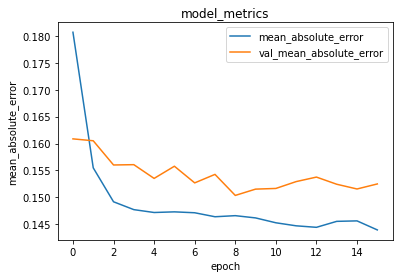

In [75]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.show()

## **Visualisasi Root Mean Squared Error**

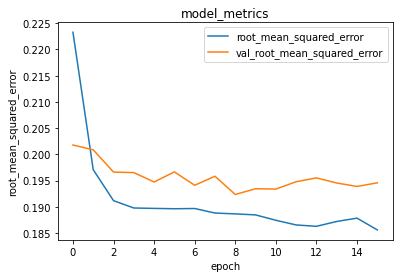

In [76]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['root_mean_squared_error', 'val_root_mean_squared_error'])
plt.show()